In [1]:
import numpy as np
import pandas as pd
import helper
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterGrid

# Load the data
# 'papers' is currently not being used in this code
papers = pd.read_csv('database_clean.csv')
embeddings_df = pd.read_csv("use_embeddings.csv")

embeddings_df_clean = embeddings_df.drop(columns=["id"])

embeddings = embeddings_df_clean.values

# train 70%, val 20%, test 10%
X_train, X_temp = train_test_split(embeddings, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=42)

X_train_paper, X_temp_paper = train_test_split(papers, test_size=0.3, random_state=42)
X_val_paper, X_test_paper = train_test_split(X_temp_paper, test_size=1/3, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (7745, 512), Validation: (2213, 512), Test: (1107, 512)


In [2]:
print(embeddings_df)

              0         1         2         3         4         5         6  \
0     -0.038129 -0.062161 -0.019255 -0.038945 -0.046120 -0.036084 -0.054072   
1     -0.023383  0.010423 -0.053019 -0.051092 -0.047135 -0.039290 -0.001832   
2     -0.045943 -0.074961  0.041563 -0.065722 -0.051982  0.028680  0.032424   
3     -0.066666 -0.047887 -0.033960 -0.065404 -0.064759  0.035115 -0.035157   
4     -0.009217 -0.051146 -0.009144  0.017567  0.027823 -0.052760 -0.018785   
...         ...       ...       ...       ...       ...       ...       ...   
11060  0.057548  0.048706  0.044268 -0.034815 -0.058915 -0.044486 -0.023411   
11061  0.022761 -0.056335 -0.064894 -0.057125  0.008123 -0.064875  0.021718   
11062 -0.001666 -0.046085 -0.017972 -0.024489  0.054256 -0.045583 -0.058886   
11063  0.045317 -0.038207  0.026376 -0.022304  0.050158 -0.026467  0.033233   
11064 -0.058042 -0.062914  0.024296 -0.045535 -0.057408  0.030156 -0.005588   

              7         8         9  ...       503 

In [3]:
def build_autoencoder(input_dim, encoding_dim=64, activation="relu", learning_rate=0.0001, l2_reg=0.01):
    # Encoder
    encoder = keras.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),
        layers.Dense(encoding_dim, activation=activation, kernel_regularizer=regularizers.l2(l2_reg)),
    ])

    # Decoder
    decoder = keras.Sequential([
        layers.Dense(input_dim, activation="sigmoid")  
    ])

    # Connect Encoder & Decoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    autoencoder = keras.Model(input_layer, decoded)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss="mse")

    return autoencoder, encoder, decoder

In [4]:
"""
# Since the dataset is very small, the autodecoder model must be simple to reduce overfitting.
input_dim = X_train.shape[1]  

encoder = keras.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
])

decoder = keras.Sequential([
    layers.Dense(input_dim, activation="sigmoid")  
])

input_layer = layers.Input(shape=(input_dim,))
encoded = encoder(input_layer)
decoded = decoder(encoded)

autoencoder = keras.Model(input_layer, decoded)
# To reduce overfitting
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss="mse")

autoencoder.summary()
"""

'\n# Since the dataset is very small, the autodecoder model must be simple to reduce overfitting.\ninput_dim = X_train.shape[1]  \n\nencoder = keras.Sequential([\n    layers.InputLayer(input_shape=(input_dim,)),\n    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),\n])\n\ndecoder = keras.Sequential([\n    layers.Dense(input_dim, activation="sigmoid")  \n])\n\ninput_layer = layers.Input(shape=(input_dim,))\nencoded = encoder(input_layer)\ndecoded = decoder(encoded)\n\nautoencoder = keras.Model(input_layer, decoded)\n# To reduce overfitting\noptimizer = keras.optimizers.Adam(learning_rate=0.0001)\nautoencoder.compile(optimizer=optimizer, loss="mse")\n\nautoencoder.summary()\n'

In [5]:
# Define the hyperparameter grid
param_grid = {
    "encoding_dim": [32],  # Number of neurons in the encoding layer
    "activation": ["relu"],  # Activation function
    "learning_rate": [0.01],  # Learning rate for Adam optimizer
    "l2_reg": [0.01]  # L2 regularization strength
}

# Generate all possible hyperparameter combinations
grid = list(ParameterGrid(param_grid))

In [6]:
best_loss = float("inf")
best_params = None
best_encoder = None
best_decoder = None
best_autoencoder = None
best_history = None

# Iterate through hyperparameter combinations
for params in grid:
    print(f"Testing params: {params}")
    
    # Build model with current hyperparameters
    autoencoder, encoder, decoder = build_autoencoder(X_train.shape[1], **params)
    
    # Train model
    history = autoencoder.fit(X_train, X_train, 
                              epochs=50, batch_size=32, 
                              validation_data=(X_val, X_val),
                              verbose=0)  # Use verbose=1 to see training progress

    # Get validation loss
    val_loss = min(history.history["val_loss"])
    
    # Check if this model is the best so far and save if it is
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_encoder = encoder
        best_decoder = decoder
        best_history = history
        best_autoencoder = autoencoder

print(f"\nBest Params: {best_params}")
print(f"Best Validation Loss: {best_loss}")

Testing params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.01, 'learning_rate': 0.01}


C:\Users\eyoel\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Best Params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.01, 'learning_rate': 0.01}
Best Validation Loss: 0.0016277014510706067


In [7]:
"""
history = autoencoder.fit(
    X_train, X_train,
    epochs= 50,
    batch_size=32,
    validation_data=(X_val, X_val),
    shuffle=True
)
"""

'\nhistory = autoencoder.fit(\n    X_train, X_train,\n    epochs= 50,\n    batch_size=32,\n    validation_data=(X_val, X_val),\n    shuffle=True\n)\n'

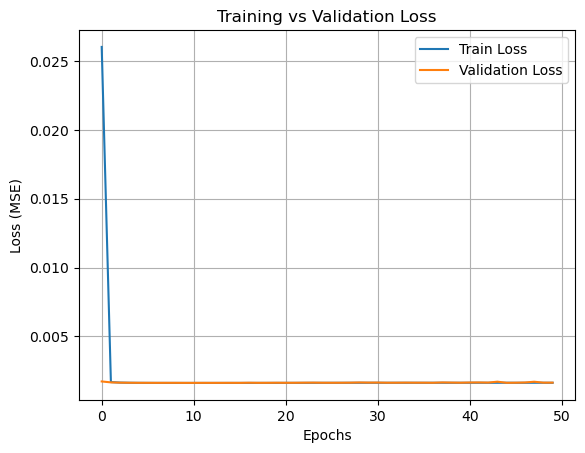

In [8]:
plt.plot(best_history.history["loss"], label="Train Loss")
plt.plot(best_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Evaluate how well the autoencoder model encodes
from sklearn.metrics import mean_squared_error

reconstructed_test = best_autoencoder.predict(X_test)

mse = mean_squared_error(X_test, reconstructed_test)

# MSE for test is much smaller than MSE for loss and val_loss. Why?
print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE) on the test set: 0.0016


In [10]:
print(X_test.shape)

(1107, 512)


In [11]:
print(reconstructed_test.shape)

(1107, 512)


In [12]:
# Encode the train and test set using the autoencoder's encoder
encoded_train = best_encoder.predict(X_train)
encoded_test = best_encoder.predict(X_test)

# Calculate the similarity matrix for both the original and encoded versions
similarity_matrix = cosine_similarity(X_test, X_train)
similarity_matrix_encoded = cosine_similarity(encoded_test, encoded_train)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix_encoded, axis=1)[:, :top_n]  

# Print and store the id of the recommended papers
recommended_paper_ids = []

for i, test_idx in enumerate(top_indices):
    recommended_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        recommended_paper_id = papers.iloc[train_idx]["id"]
        recommended_for_test.append(recommended_paper_id)
        print(f"  {j+1}. Recommended Paper ID: {recommended_paper_id} (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f}) (Similarity: {similarity_matrix[i, train_idx]:.4f})")
    recommended_paper_ids.append(recommended_for_test)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]  

# Print and store the id of the recommended papers
best_paper_ids = []

for i, test_idx in enumerate(top_indices):
    best_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        best_paper_id = papers.iloc[train_idx]["id"]
        best_for_test.append(best_paper_id)
        print(f"  {j+1}. Unencoded Recommended Paper ID: {best_paper_id} (Similarity: {similarity_matrix[i, train_idx]:.4f}) (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f})")
    best_paper_ids.append(best_for_test)

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step

Test Paper 1:
  1. Recommended Paper ID: 3d5bca51-7bef-48a3-80a7-e0727412d056 (Encoded_Similarity: 1.0000) (Similarity: 0.2065)
  2. Recommended Paper ID: e796b712-482b-442d-a5fa-489a8c3b639f (Encoded_Similarity: 1.0000) (Similarity: 0.1460)
  3. Recommended Paper ID: 1a3390c7-0336-452c-971b-e11204672c3e (Encoded_Similarity: 1.0000) (Similarity: 0.2025)
  4. Recommended Paper ID: 9de66ed2-049c-4401-a056-af5ab6f143b4 (Encoded_Similarity: 1.0000) (Similarity: 0.1892)
  5. Recommended Paper ID: af61dba6-3625-4e6f-a682-5ff5ca40c84f (Encoded_Similarity: 1.0000) (Similarity: 0.0970)
  6. Recommended Paper ID: a0724e12-5be5-4fb7-9e15-8785a35e7176 (Encoded_Similarity: 1.0000) (Similarity: 0.1691)
  7. Recommended Paper ID: ca553566-c563-412e-8b2b-79f2d2629b20 (Encoded_Similarity: 1.0000) (Similarity: 0.1172)
  8. Recommended Paper ID: 257de229-b348-47c7-83f6-3290fda05be6 (Encoded_Similarity: 1.0000) (Similarit

In [13]:
"""
# Calculates the percentages of how many recommended papers using the autoencoder exist in the recommended papers without using the autoencoder for each test paper
overlap_percentages = []

for recommended, best in zip(recommended_paper_ids, best_paper_ids):
    recommended_set = set(recommended)
    best_set = set(best)
    
    intersection = recommended_set.intersection(best_set)
    
    overlap_percentage = len(intersection) / len(best_set) * 100
    
    overlap_percentages.append(overlap_percentage)

average_overlap = sum(overlap_percentages) / len(overlap_percentages)

for i, overlap in enumerate(overlap_percentages):
    print(f"Test Paper {i+1}: {overlap:.2f}% overlap")

# Calculates the average overlap percentage for all test papers
print(f"\nAverage overlap: {average_overlap:.2f}%")
"""

'\n# Calculates the percentages of how many recommended papers using the autoencoder exist in the recommended papers without using the autoencoder for each test paper\noverlap_percentages = []\n\nfor recommended, best in zip(recommended_paper_ids, best_paper_ids):\n    recommended_set = set(recommended)\n    best_set = set(best)\n    \n    intersection = recommended_set.intersection(best_set)\n    \n    overlap_percentage = len(intersection) / len(best_set) * 100\n    \n    overlap_percentages.append(overlap_percentage)\n\naverage_overlap = sum(overlap_percentages) / len(overlap_percentages)\n\nfor i, overlap in enumerate(overlap_percentages):\n    print(f"Test Paper {i+1}: {overlap:.2f}% overlap")\n\n# Calculates the average overlap percentage for all test papers\nprint(f"\nAverage overlap: {average_overlap:.2f}%")\n'

In [14]:
similarity_mean, similarity_median = helper.cosine_similarity_mean_median(similarity_matrix)
print(similarity_mean)
print(similarity_median)

[0.36683727 0.54388692 0.62615334 ... 0.54182528 0.69241493 0.62370943]
[0.3643092  0.5377832  0.61065728 ... 0.53506462 0.69268256 0.61628882]


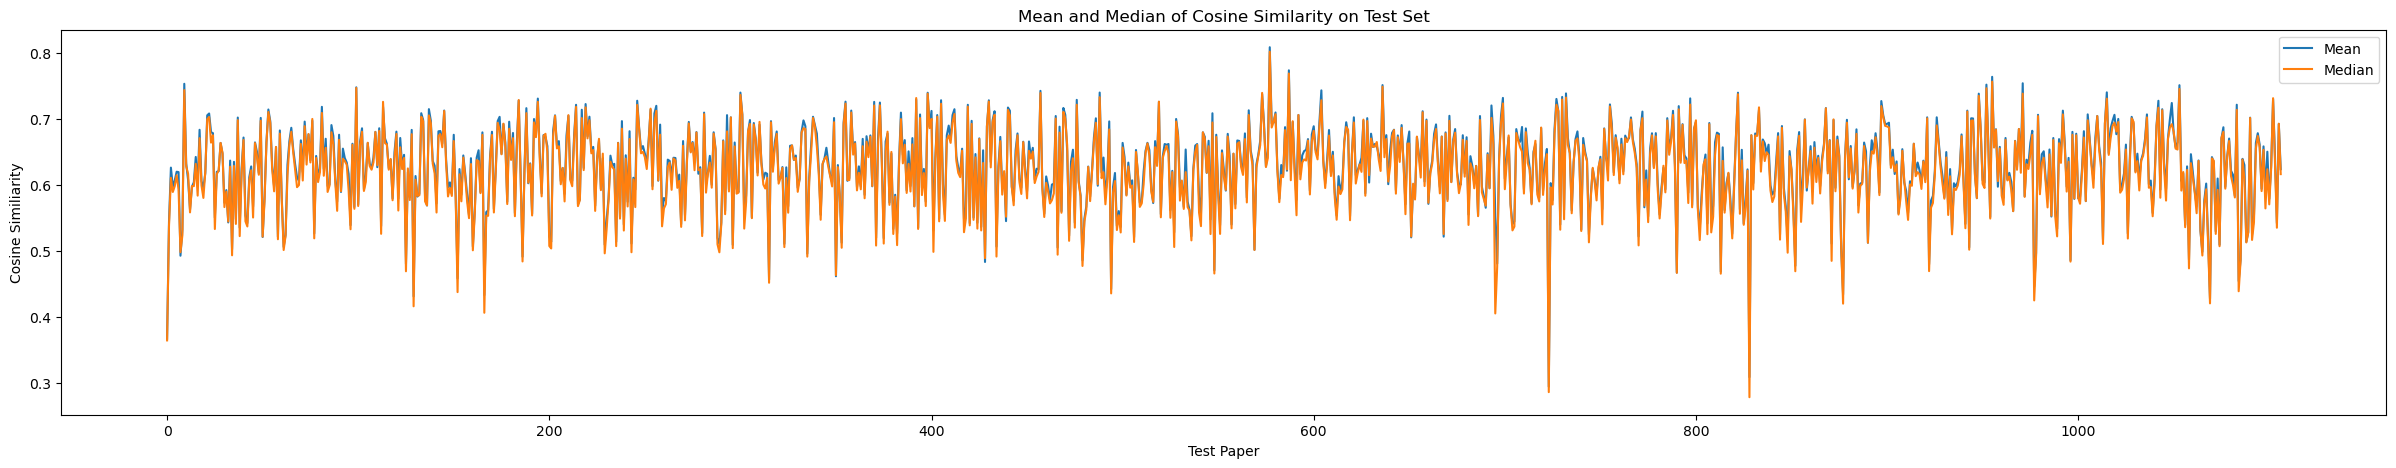

In [15]:
helper.plot_cosine_similarity(similarity_mean, similarity_median)

In [16]:
top10_texts = []

np_recommended_paper_ids = np.array(recommended_paper_ids)

for top10_ids in np_recommended_paper_ids:
    top10_text = []
    for paper_id in top10_ids:
        top10_text.append(papers.loc[papers["id"] == paper_id, "abstract"].values)
    top10_texts.append(top10_text)

test_texts = list(X_test_paper["abstract"])

tfidf_matrix, test_vectors, top10_vectors, vectorizer = helper.compute_tfidf_similarity_v(test_texts, top10_texts)
print(tfidf_matrix)
"""
# Convert to DataFrame for better visualization
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_tfidf, cmap="Blues", annot=True, fmt=".2f")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.title("TF-IDF Matrix Heatmap")
plt.show()
"""

  (0, 845)	0.242723418321502
  (0, 175)	0.31225255274956404
  (0, 884)	0.47031766069332154
  (0, 118)	0.18562101986011711
  (0, 2717)	0.2005266283990091
  (0, 1003)	0.1924142105383143
  (0, 4967)	0.12305072105403247
  (0, 2637)	0.48764113415971533
  (0, 4194)	0.2928709036934529
  (0, 3004)	0.1237903111127914
  (0, 4772)	0.2998369836879734
  (0, 2671)	0.19720740062874614
  (0, 1890)	0.1669428786430841
  (1, 3212)	0.031094255399564275
  (1, 3450)	0.0523565606384655
  (1, 3324)	0.06530983275211584
  (1, 3064)	0.041549425534379195
  (1, 2893)	0.07478610549987581
  (1, 1196)	0.03590250122998269
  (1, 4223)	0.3128444912411649
  (1, 1644)	0.07373446247859866
  (1, 1134)	0.11913429714648685
  (1, 4264)	0.19847052706107038
  (1, 2148)	0.11554653088584617
  (1, 4601)	0.16686295500305082
  :	:
  (2213, 2103)	0.03250813683175861
  (2213, 1984)	0.03429380092725046
  (2213, 2159)	0.02682065186964346
  (2213, 3775)	0.03270520337183108
  (2213, 1589)	0.022364966696009066
  (2213, 608)	0.02674354436083

'\n# Convert to DataFrame for better visualization\ndf_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())\n\n# Plot heatmap\nplt.figure(figsize=(10, 6))\nsns.heatmap(df_tfidf, cmap="Blues", annot=True, fmt=".2f")\nplt.xlabel("Terms")\nplt.ylabel("Documents")\nplt.title("TF-IDF Matrix Heatmap")\nplt.show()\n'

In [17]:
print(test_vectors)

  (0, 845)	0.242723418321502
  (0, 175)	0.31225255274956404
  (0, 884)	0.47031766069332154
  (0, 118)	0.18562101986011711
  (0, 2717)	0.2005266283990091
  (0, 1003)	0.1924142105383143
  (0, 4967)	0.12305072105403247
  (0, 2637)	0.48764113415971533
  (0, 4194)	0.2928709036934529
  (0, 3004)	0.1237903111127914
  (0, 4772)	0.2998369836879734
  (0, 2671)	0.19720740062874614
  (0, 1890)	0.1669428786430841
  (1, 3212)	0.031094255399564275
  (1, 3450)	0.0523565606384655
  (1, 3324)	0.06530983275211584
  (1, 3064)	0.041549425534379195
  (1, 2893)	0.07478610549987581
  (1, 1196)	0.03590250122998269
  (1, 4223)	0.3128444912411649
  (1, 1644)	0.07373446247859866
  (1, 1134)	0.11913429714648685
  (1, 4264)	0.19847052706107038
  (1, 2148)	0.11554653088584617
  (1, 4601)	0.16686295500305082
  :	:
  (1106, 1693)	0.04618794613177278
  (1106, 2516)	0.05386854285293627
  (1106, 2102)	0.051482149144228315
  (1106, 4049)	0.09257406424377157
  (1106, 4354)	0.15450083571943848
  (1106, 4352)	0.0645146960990

In [18]:
print(top10_vectors)

[[[0.         0.         0.         ... 0.         0.05221176 0.        ]
  [0.         0.07683485 0.         ... 0.01900816 0.         0.        ]
  [0.0285137  0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.02530878 ... 0.         0.09152712 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.02128879 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.0397625  0.         0.         ... 0.         0.04171723 0.03264692]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.03800658 ... 0.         0.03436192 0.        ]
  [0.         0.      

In [19]:
emb_paper_id = embeddings_df["id"].tolist()
embeddings = embeddings_df.drop("id", axis=1).values.tolist()


top10_embeddings = []

np_recommended_paper_ids = np.array(recommended_paper_ids)

for top10_ids in np_recommended_paper_ids:
    top10_embedding = []
    for paper_id in top10_ids:
        top10_embedding.append(embeddings[emb_paper_id.index(paper_id)])
    top10_embeddings.append(top10_embedding)

top10_embeddings = np.array(top10_embeddings)
test_embeddings = np.array(X_test)

print(top10_embeddings.shape)
print(test_embeddings.shape)

(1107, 10, 512)
(1107, 512)


In [20]:
correlation_mean, correlation_median = helper.compute_pearson_correlation(test_embeddings, top10_embeddings)
print(correlation_mean)

[0.14491568059748175, 0.28810223008157565, 0.28732424864246275, 0.27210178719226186, 0.28836411374114573, 0.3541954625689069, 0.24934788263310792, 0.23514697574510274, 0.2327229984246047, 0.40897957627850995, 0.37067122328557556, 0.29742506601448, 0.2229258692799408, 0.30210621148059863, 0.2843734581929412, 0.31254499777465516, 0.3817524300026679, 0.35237485244675987, 0.3295508458687937, 0.3368341909277064, 0.34984573877993463, 0.347934875957438, 0.3848456437354114, 0.23533149212549803, 0.36242926637015754, 0.27749523265890075, 0.3703055438514955, 0.2892009596200201, 0.438621424526534, 0.32131904371971626, 0.28085018782343074, 0.360749096462783, 0.2042716393504639, 0.27656951053869977, 0.20369304129082896, 0.38821411450493637, 0.1835394451381752, 0.38308604745813307, 0.2248706623212536, 0.3053409175419703, 0.2329433582285557, 0.28274934699321647, 0.24523418766367425, 0.31830908569227123, 0.24110614818261622, 0.2676684557901986, 0.30530319360553554, 0.36562092424321324, 0.35988104605942

In [21]:
print(correlation_median)

[0.14447012296369638, 0.2974139097103817, 0.29961416022561177, 0.3013796112868221, 0.28296670036490745, 0.37635772069767637, 0.23767862295492562, 0.22770779579583855, 0.20575631460113974, 0.3950352565158753, 0.3380290380957944, 0.2905924147911283, 0.20705027604266313, 0.2990265487558117, 0.3121289631665263, 0.30911799563298803, 0.3861670860718597, 0.34513691380861805, 0.328800221758191, 0.31771158113046183, 0.3455067040398462, 0.3276410722830523, 0.35373766609388135, 0.23118137805697692, 0.3431396731771544, 0.2828173221936075, 0.3677437152463342, 0.24652586345268357, 0.4445539823564575, 0.32389680351175854, 0.28686528773251974, 0.33210546096101384, 0.2015756055398673, 0.2981106025602088, 0.20251507077702047, 0.42553277510178666, 0.17560410621872657, 0.4038344840303102, 0.2252701293022612, 0.28475305047096705, 0.23060235578562274, 0.27042145980401633, 0.26312596769698077, 0.32233782085955076, 0.25023473126539464, 0.26493440848490774, 0.31702808383309855, 0.37210970135942856, 0.385433849

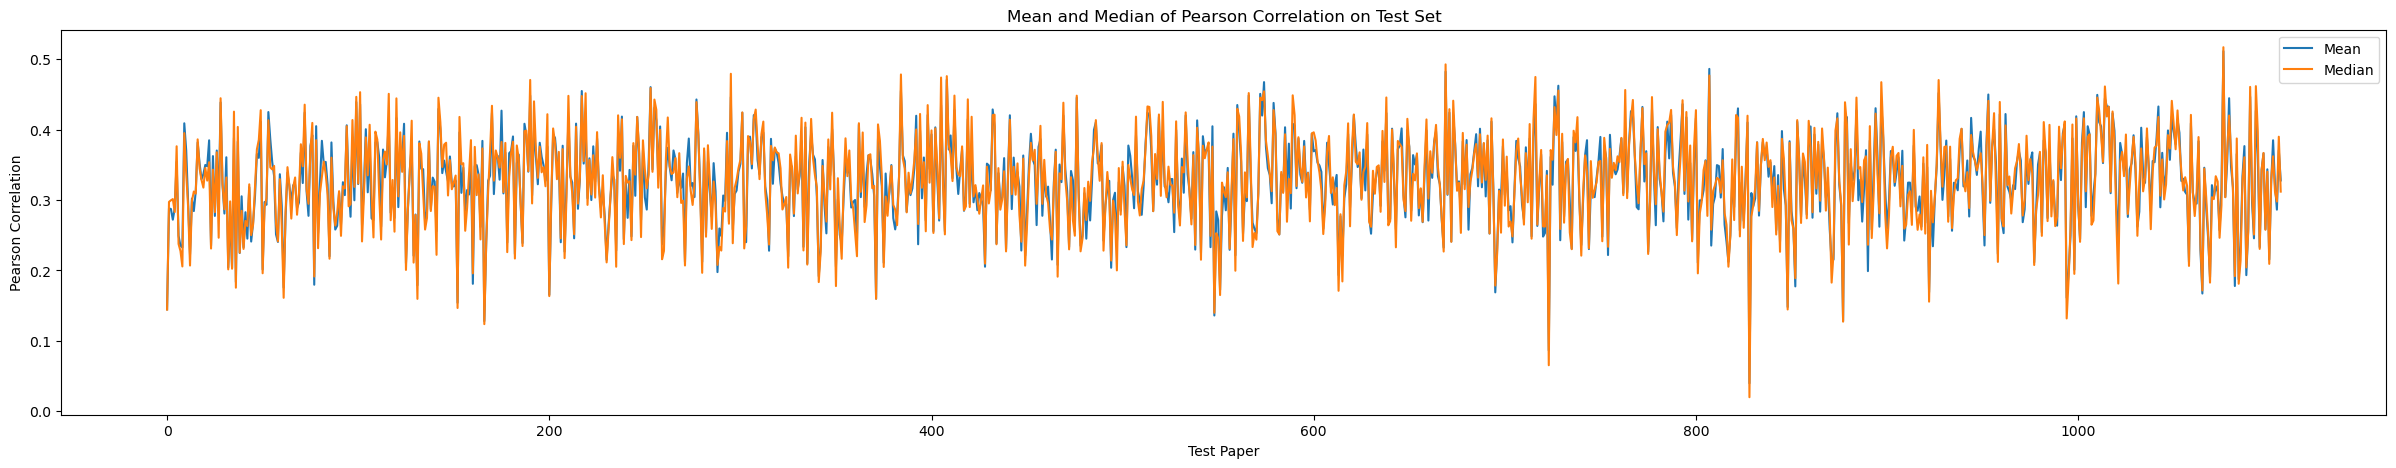

In [23]:
helper.plot_pearson_correlation(correlation_mean, correlation_median)

In [22]:
# Saves the model
autoencoder.save('autoencoder_model.keras')